In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm
from scipy import stats

from src.utils import runge_kutta, lorentz_ode, mae, mse
from src.wishart import Wishart

from sklearn.cluster import DBSCAN

In [2]:
xs, ys, zs = pd.read_csv("../data/lorentz_time_series.csv", index_col=0).values.T

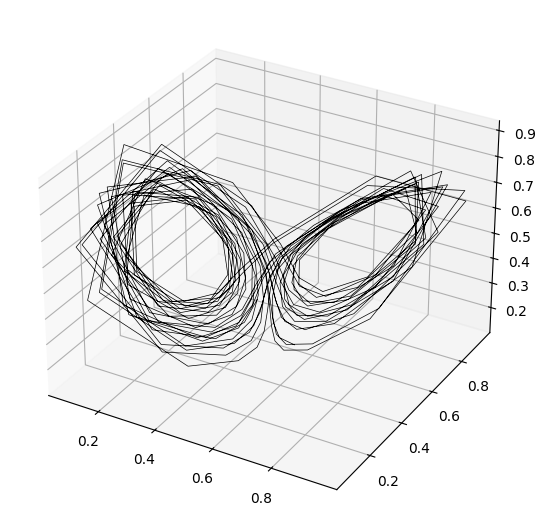

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6.66, 6.66), subplot_kw={"projection": "3d"})
ax.plot(xs[1000:1300], ys[1000:1300], zs[1000:1300], lw=0.5, c='black')
plt.show()

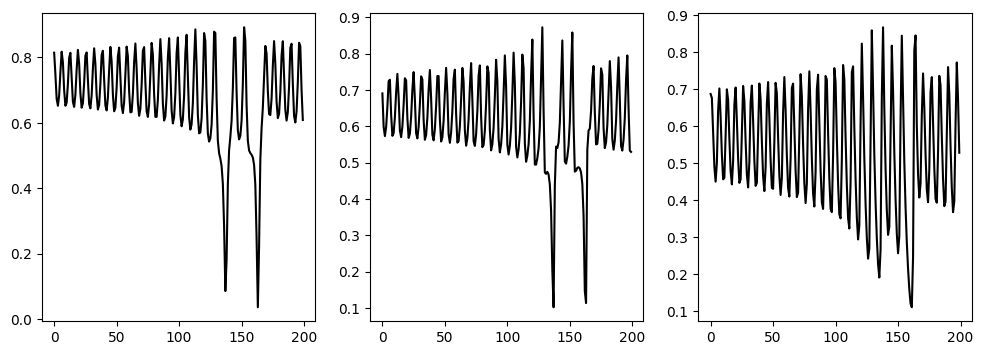

In [4]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].plot(xs[-200:], c='black')
axs[1].plot(ys[-200:], c='black')
axs[2].plot(zs[-200:], c='black')
plt.show()

In [5]:
from predictive_clustering import PredictiveClustering
#dbscan approach
pc = PredictiveClustering(10, 4, choose_prediction='dbscan_mode', classify_point='dbscan',
                                 unpredicted_ratio = 3., entropy_max=1.8, eps=0.01)

#entropy approach
pc = PredictiveClustering(10, 4, choose_prediction='dbscan_mode', classify_point='entropy', entropy_max=1.8, eps=0.01)

In [6]:
x_train, x_test = xs[:10000], xs[10000:]

In [7]:
pc.generate_motives(x_train)

In [8]:
y_pred_matrix = []
y_true_matrix = []

horizon = 100

for i in range(50):
    y_pred_matrix.append(pc.predict(x_train, horizon))
    y_true_matrix.append(x_test[:horizon])

    x_train = np.append(x_train, x_test[0])
    x_test = x_test[1:]

In [9]:
y_true_matrix = np.array(y_true_matrix)
y_pred_matrix = np.array(y_pred_matrix)

In [10]:
which = "entropy"
np.save(f"../data/y_pred_{which}_mode.npy", y_pred_matrix)
np.save(f"../data/y_true_{which}_mode.npy", y_true_matrix)

In [11]:
y_true = np.load("../data/y_true_entropy_mode.npy")
y_pred_dbscan = np.load("../data/y_pred_dbscan_mode.npy")
y_pred_entropy = np.load("../data/y_pred_entropy_mode.npy")

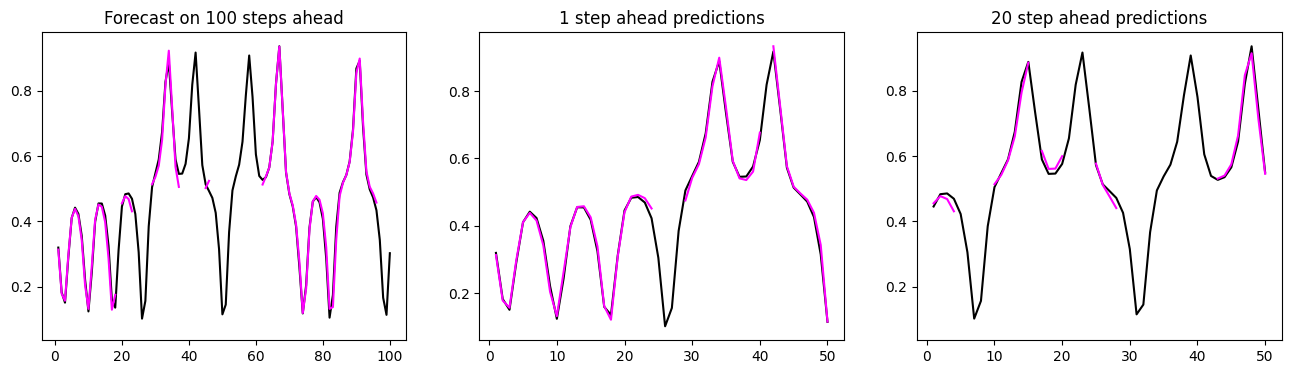

In [12]:
fig, axs = plt.subplots(1,3,figsize=(16,4))

axs[0].set_title("Forecast on 100 steps ahead")
axs[0].plot(np.arange(1, 101), y_true[0], c='black')
axs[0].plot(np.arange(1, 101), y_pred_entropy[0], c='magenta')


axs[1].set_title("1 step ahead predictions")
axs[1].plot(np.arange(1, 51), y_true[:, 0], c='black')
axs[1].plot(np.arange(1, 51), y_pred_entropy[:, 0], c='magenta')

axs[2].set_title("20 step ahead predictions")
axs[2].plot(np.arange(1, 51), y_true[:, 19], c='black')
axs[2].plot(np.arange(1, 51), y_pred_entropy[:, 19], c='magenta')

plt.savefig("entropy_predictions")

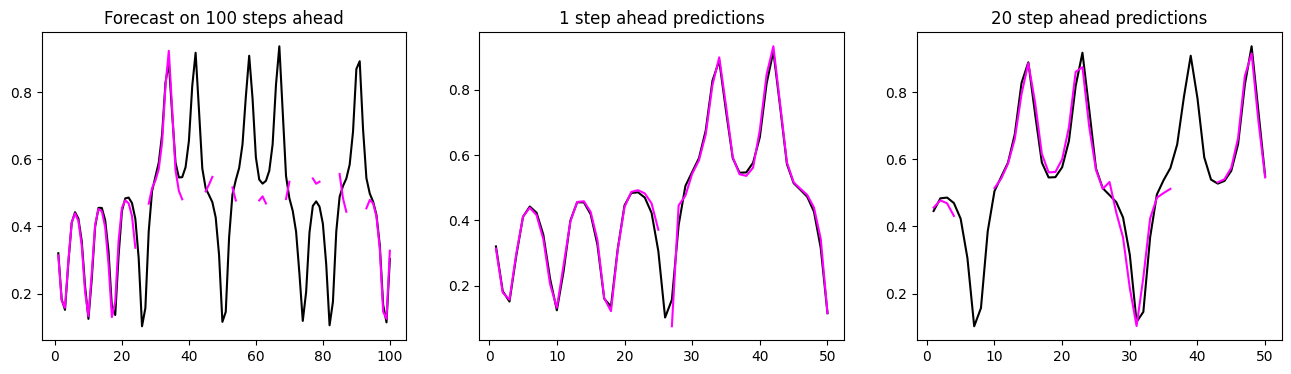

In [13]:
fig, axs = plt.subplots(1,3,figsize=(16,4))

axs[0].set_title("Forecast on 100 steps ahead")
axs[0].plot(np.arange(1, 101), y_true[0], c='black')
axs[0].plot(np.arange(1, 101), y_pred_dbscan[0], c='magenta')


axs[1].set_title("1 step ahead predictions")
axs[1].plot(np.arange(1, 51), y_true[:, 0], c='black')
axs[1].plot(np.arange(1, 51), y_pred_dbscan[:, 0], c='magenta')

axs[2].set_title("20 step ahead predictions")
axs[2].plot(np.arange(1, 51), y_true[:, 19], c='black')
axs[2].plot(np.arange(1, 51), y_pred_dbscan[:, 19], c='magenta')

plt.savefig("dbscan_predictions")

In [14]:
maes1 = []
pct_nonpred1 = []
maes2 = []
pct_nonpred2 = []
for i in range(100):
    maes1.append(mae(y_true[:,i], y_pred_dbscan[:,i]))
    maes2.append(mae(y_true[:,i], y_pred_entropy[:,i]))
    pct_nonpred1.append(np.isnan(y_pred_dbscan[:,i]).sum() / len(y_pred_dbscan[:,i]))
    pct_nonpred2.append(np.isnan(y_pred_entropy[:,i]).sum() / len(y_pred_entropy[:,i]))

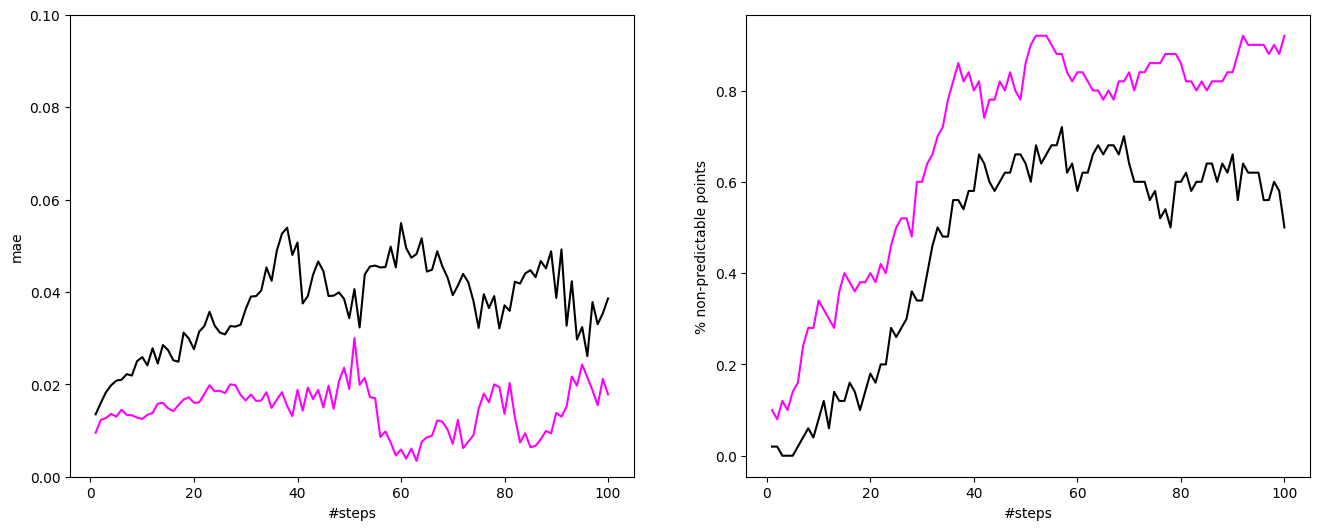

In [15]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

axs[0].plot(range(1,101), maes1, c='black')
axs[0].plot(range(1,101), maes2, c='magenta')
axs[0].set_ylabel('mae')
axs[0].set_xlabel('#steps')
axs[0].set_ylim(0, 0.1)

axs[1].plot(range(1,101), pct_nonpred1, c='black')
axs[1].plot(range(1,101), pct_nonpred2, c='magenta')
axs[1].set_ylabel('% non-predictable points')
axs[1].set_xlabel('#steps')

plt.savefig("lorentz_res")

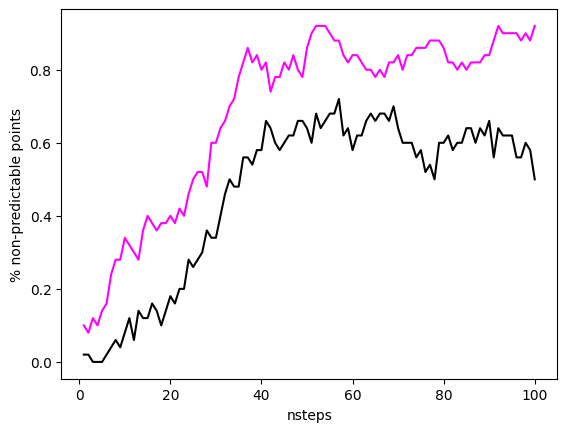

In [16]:
plt.plot(range(1,101), pct_nonpred1, c='black', label='DBSCAN')
plt.plot(range(1,101), pct_nonpred2, c='magenta', label='ENTROPY')

plt.ylabel('% non-predictable points')
plt.xlabel('nsteps')
plt.savefig("nonpred")
plt.show()